# Chapter 14 How to Develop MLPs, CNNs and LSTMs for Univariate Forecasting

In this tutorial, you will discover how to develop a suite of deep learning models for univariate time series forecasting. After completing this tutorial, you will know:
- How to develop a robust test harness using walk-forward validation for evaluating the performance of neural network models.
- How to develop and evaluate simple Multilayer Perceptron and convolutional neural networks for time series forecasting.
- How to develop and evaluate LSTMs, CNN-LSTMs, and ConvLSTM neural network models for time series forecasting.

## 14.1 Tutorial Overview

This tutorial is divided into five parts; they are: 
1. Time Series Problem
2. Model Evaluation Test Harness
3. Multilayer Perceptron Model
4. Convolutional Neural Network Model 
5. Recurrent Neural Network Models

## 14.2 Time Series Problem

In this tutorial we will focus on one dataset and use it as the context to demonstrate the development of a range of deep learning models for univariate time series forecasting. We will use the monthly car sales dataset as this context as it includes the complexity of both trend and seasonal elements.

The performance of the naive model provides a lower bound on a model that is considered skillful. Any model that achieves a predictive performance of lower than 1,841.15 on the last 12 months has skill. The performance of the SARIMA model provides a measure of a good model on the problem. Any model that achieves a predictive performance lower than 1,551.84 on the last 12 months should be adopted over a SARIMA model. Now that we have defined our problem and expectations of model skill, we can look at defining the test harness.

朴素模型的性能为被认为是熟练的模型提供了下限。任何在过去 12 个月内实现低于 1,841.15 的预测性能的模型都具有技能。SARIMA模型的性能提供了衡量该问题的良好模型的指标。任何在过去 12 个月内实现低于 1,551.84 的预测性能的模型都应采用 SARIMA 模型。现在我们已经定义了模型技能的问题和期望，我们可以看看定义测试工具。

## 14.3 Model Evaluation Test Harness模型评价测试工具

This section is divided into the following parts:
1. Train-Test Split
2. Series as Supervised Learning
3. Walk-Forward Validation
4. Repeat Evaluation
5. Summarize Performance 
6. Worked Example

### 14.3.1 Train-Test Split

In [1]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

### 14.3.2 Series as Supervised Learning

In [ ]:
# (t-1), (t) Nan, 1
# 1, 2
# 2, 3
# 3, 4
# 4, NaN

In [2]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

### 14.3.3 Walk-Forward Validation

Time series forecasting models can be evaluated on a test set using walk-forward validation. Walk-forward validation is an approach where the model makes a forecast for each observation in the test dataset one at a time. After each forecast is made for a time step in the test dataset, the true observation for the forecast is added to the test dataset and made available to the model. Simpler models can be refit with the observation prior to making the subsequent prediction. More complex models, such as neural networks, are not refit given the much greater computational cost. Nevertheless, the true observation for the time step can then be used as part of the input for making the prediction on the next time step.

可以使用前行验证在测试集上评估时序预测模型。前行验证是一种方法，其中模型对测试数据集中的每个观测值进行预测，一次预测一个。在对测试数据集中的某个时间步长进行每个预测后，预测的真实观测值将添加到测试数据集中，并可供模型使用。在进行后续预测之前，可以使用观测结果对更简单的模型进行修改。更复杂的模型，如神经网络，没有被改装，因为计算成本要高得多。尽管如此，时间步长的真实观测值可以用作对下一个时间步进行预测的输入的一部分。

In [3]:
# fit a model
def model_fit(train, config):
    return None

In [4]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    return 0.0

In [5]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [7]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions) 
    print(' > %.3f' % error)
    return error

### 14.3.4 Repeat Evaluation

Neural network models are stochastic. This means that, given the same model configuration and the same training dataset, a different internal set of weights will result each time the model is trained that will in turn have a different performance. This is a benefit, allowing the model to be adaptive and find high performing configurations to complex problems. It is also a problem when evaluating the performance of a model and in choosing a final model to use to make predictions.

To address model evaluation, we will evaluate a model configuration multiple times via walk-forward validation and report the error as the average error across each evaluation. This is not always possible for large neural networks and may only make sense for small networks that can be fit in minutes or hours. The repeat evaluate() function below implements this and allows the number of repeats to be specified as an optional parameter that defaults to 30 and returns a list of model performance scores: in this case, RMSE values.

神经网络模型是随机的。这意味着，给定相同的模型配置和相同的训练数据集，每次训练模型时都会产生不同的内部权重集，而这些权重反过来又具有不同的性能。这是一个好处，允许模型具有适应性，并为复杂问题找到高性能配置。在评估模型的性能和选择要用于进行预测的最终模型时，这也是一个问题。

为了解决模型评估问题，我们将通过前行验证多次评估模型配置，并将错误报告为每次评估的平均误差。对于大型神经网络来说，这并不总是可行的，并且可能只对可以在几分钟或几小时内适应的小型网络有意义。下面的 repeat evaluate（） 函数实现了这一点，并允许将重复次数指定为默认为 30 的可选参数，并返回模型性能分数列表：在本例中为 RMSE 值。

In [8]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

### 14.3.5 Summarize Performance

Finally, we need to summarize the performance of a model from the multiple repeats. We will summarize the performance first using summary statistics, specifically the mean and the standard deviation. We will also plot the distribution of model performance scores using a box and whisker plot to help get an idea of the spread of performance. The summarize scores() function below implements this, taking the name of the model that was evaluated and the list of scores from each repeated evaluation, printing the summary and showing a plot.

最后，我们需要从多次重复中总结模型的性能。我们将首先使用汇总统计数据来总结性能，特别是平均值和标准差。我们还将使用箱形图绘制模型性能分数的分布图，以帮助了解性能的分布。下面的 summary scores（） 函数实现了这一点，它采用被评估模型的名称和每次重复评估的分数列表，打印摘要并显示绘图。

In [9]:
# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std)) 
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

### 14.3.6 Worked Example

 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
persistence: 1841.156 RMSE (+/- 0.000)


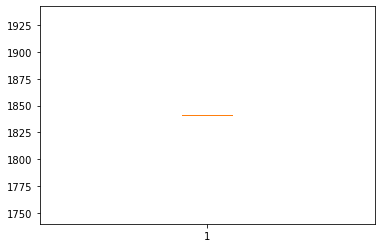

In [12]:
# persistence forecast for monthly car sales dataset
from math import sqrt
from numpy import median
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
    return None

# forecast with a pre-fit model
def model_predict(model, history, config):
    values = list()
    for offset in config:
        values.append(history[-offset])
    return median(values)

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions) 
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores
# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std)) 
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()
    
series = read_csv('monthly-car-sales.csv', header=0, index_col=0) 
data = series.values
# data split
n_test = 12
# define config
config = [12, 24, 36]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('persistence', scores)

## 14.4 Multilayer Perceptron Model

MLPs can be used for time series forecasting by taking multiple observations at prior time steps, called lag observations, and using them as input features and predicting one or more time steps from those observations. This is exactly the framing of the problem provided by the series to supervised() function in the previous section. The training dataset is therefore a list of samples, where each sample has some number of observations from months prior to the time being forecasted, and the forecast is the next month in the sequence.

MLP 可用于时间序列预测，方法是在先前的时间步长中获取多个观测值（称为滞后观测值），并将其用作输入特征并从这些观测值中预测一个或多个时间步长。这正是上一节中该系列为 supervised（） 函数提供的问题的框架。因此，训练数据集是一个样本列表，其中每个样本都有预测时间之前的几个月的一定数量的观测值，并且预测是序列中的下一个月。

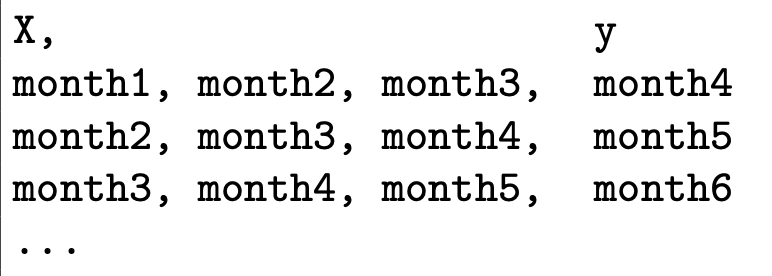

In [ ]:
# define model
model = Sequential()
model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

The model will be fit for some number of training epochs (exposures to the training data) and batch size can be specified to define how often the weights are updated within each epoch. The model fit() function for fitting an MLP model on the training dataset is listed below. The function expects the config to be a list with the following configuration hyperparameters:
- n input: The number of lag observations to use as input to the model.
- n nodes: The number of nodes to use in the hidden layer.
- n epochs: The number of times to expose the model to the whole training dataset.
- n batch: The number of samples within an epoch after which the weights are updated.

In [ ]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input)) 
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0) 
    return model

In [ ]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _ = config
    # prepare data
    x_input = array(history[-n_input:]).reshape(1, n_input)
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

- n input: 24 (e.g. 24 months) 
- n nodes: 500
- n epochs: 100
- n batch: 100

This configuration can be defined as a list:

In [ ]:
# define config
config = [24, 500, 100, 100]

 > 1629.281
 > 1343.343
 > 1665.148
 > 1583.563
 > 1719.636
 > 1602.476
 > 1502.571
 > 1772.431
 > 1394.605
 > 1429.118
 > 1594.083
 > 1558.578
 > 1435.953
 > 1685.626
 > 1672.595
 > 1617.624
 > 1799.536
 > 1430.426
 > 1503.072
 > 1286.273
 > 1460.818
 > 1492.245
 > 1569.725
 > 1544.049
 > 1574.214
 > 1420.438
 > 1764.990
 > 1378.805
 > 1327.286
 > 1718.018
mlp: 1549.217 RMSE (+/- 137.739)


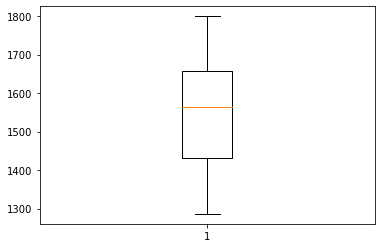

In [17]:
# evaluate mlp for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input)) 
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0) 
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _ = config
    # prepare data
    x_input = array(history[-n_input:]).reshape(1, n_input)
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions) 
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std)) # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()
    
    
series = read_csv('monthly-car-sales.csv', header=0, index_col=0) 
data = series.values
# data split
n_test = 12
# define config
config = [24, 500, 100, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('mlp', scores)

## 14.5 Convolutional Neural Network Model

 > 1451.538
 > 1486.384
 > 1442.719
 > 1557.635
 > 1498.819
 > 1452.701
 > 1530.966
 > 1626.774
 > 1558.660
 > 1527.186
 > 1538.004
 > 1497.427
 > 1568.837
 > 1568.099
 > 1604.038
 > 1546.766
 > 1479.981
 > 1488.818
 > 1761.407
 > 1567.610
 > 1676.750
 > 1659.802
 > 1591.545
 > 1529.322
 > 1537.797
 > 1533.257
 > 1535.060
 > 1537.240
 > 1537.177
 > 1760.616
cnn: 1555.098 RMSE (+/- 77.299)


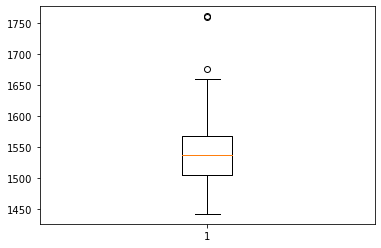

In [21]:
# evaluate mlp for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_filters, n_kernel, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(n_filters, n_kernel, activation='relu', input_shape=(n_input, 1)))
    model.add(Conv1D(n_filters, n_kernel, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model


# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, _ = config
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions) 
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std)) # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()
     
series = read_csv('monthly-car-sales.csv', header=0, index_col=0) 
data = series.values
# data split
n_test = 12
# define config
config = [36, 256, 3, 100, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn', scores)

## 14.6 Recurrent Neural Network Models

Recurrent neural networks, or RNNs, are those types of neural networks that use an output of the network from a prior step as an input in attempt to automatically learn across sequence data. The Long Short-Term Memory, or LSTM, network is a type of RNN whose implementation addresses the general difficulties in training RNNs on sequence data that results in a stable model. It achieves this by learning the weights for internal gates that control the recurrent connections within each node. Although developed for sequence data, LSTMs have not proven effective on time series forecasting problems where the output is a function of recent observations, e.g. an autoregressive type forecasting problem, such as the car sales dataset. Nevertheless, we can develop LSTM models for autoregressive problems and use them as a point of comparison with other neural network models.

递归神经网络 （RNN） 是那些使用前一步的网络输出作为输入以尝试自动学习序列数据的神经网络类型。长短期记忆（LSTM）网络是一种RNN，其实现解决了在序列数据上训练RNN的一般困难，从而产生稳定的模型。它通过学习控制每个节点内循环连接的内部门的权重来实现这一点。尽管 LSTM 是为序列数据开发的，但在时间序列预测问题上尚未证明有效，其中输出是最近观测值的函数，例如自回归类型预测问题，例如汽车销售数据集。尽管如此，我们可以为自回归问题开发 LSTM 模型，并将其用作与其他神经网络模型的比较点。

- Vanilla LSTM: The LSTM network as-is.
- CNN-LSTM: A CNN network that learns input features and an LSTM that interprets
them.
- ConvLSTM: A combination of CNNs and LSTMs where the LSTM units read input data using the convolutional process of a CNN.

- 香草LSTM：LSTM网络原样。
- CNN-LSTM：学习输入特征的CNN网络和解释输入特征的LSTM他们。
- ConvLSTM：CNN和LSTM的组合，其中LSTM单元使用CNN的卷积过程读取输入数据

### 14.6.1 LSTM

In [22]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

Model hyperparameters were chosen with a little trial and error and are listed below. The model may not be optimal for the problem and improvements could be made via grid searching. For details on how, see Chapter 15.
- n input: 36 (i.e. 3 years or 3 × 12)
- n nodes: 50
- n epochs: 100
- n batch: 100 (i.e. batch gradient descent) 
- n diff: 12 (i.e. seasonal difference)


In [23]:
# define config
config = [36, 50, 100, 100, 12]

**Tying all of this together, the complete example is listed below.**

 > 2084.880
 > 2112.878
 > 2137.161
 > 2101.272
 > 2147.722
 > 2161.797
 > 2057.479
 > 2092.652
 > 2009.579
 > 1970.415
 > 2201.971
 > 2102.878
 > 2079.842
 > 2122.863
 > 2021.844
 > 2130.668
 > 2066.279
 > 2402.782
 > 2173.830
 > 2077.434
 > 1991.459
 > 2124.994
 > 2064.968
 > 2078.759
 > 2080.539
 > 2210.708
 > 2182.131
 > 2176.727
 > 2132.380
 > 2076.324
lstm: 2112.507 RMSE (+/- 79.190)


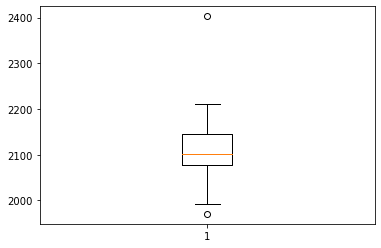

In [24]:
# evaluate lstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot


# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1))) 
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0) 
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions) 
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std)) # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()
     
series = read_csv('monthly-car-sales.csv', header=0, index_col=0) 
data = series.values
# data split
n_test = 12
# define config
config = [36, 50, 100, 100, 12]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('lstm', scores)

**LSTMs, at least alone, are perhaps a bad fit for autoregressive-type sequence prediction problems.**

### 14.6.2 CNN LSTM

 the CNN model is capable of automatically learning and extracting features from the raw sequence data without scaling or differencing. We can combine this capability with the LSTM where a CNN model is applied to sub-sequences of input data, the results of which together form a time series of extracted features that can be interpreted by an LSTM model. This combination of a CNN model used to read multiple subsequences over time by an LSTM is called a **CNN-LSTM model**.

The number of lag observations per sample is simply (n seq × n steps). This is a 4-dimensional input array now with the dimensions: [samples, subsequences, timesteps, features]. The same CNN model must be applied to each input subsequence. We can achieve this by wrapping the entire CNN model in a TimeDistributed layer wrapper.

每个样本的滞后观测值数量很简单（n 序列× n 步）。这是一个 4 维输入数组，现在具有以下维度：[样本、子序列、时间步长、特征]。必须将相同的 CNN 模型应用于每个输入子序列。我们可以通过将整个CNN模型包装在TimeDistributed层包装器中来实现这一点。

In [ ]:
# define CNN input model
model = Sequential()
model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu',
input_shape=(None,n_steps,1)))) 
model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu'))) 
model.add(TimeDistributed(MaxPooling1D())) 
model.add(TimeDistributed(Flatten()))

# define LSTM and output model
model.add(LSTM(n_nodes, activation='relu')) 
model.add(Dense(n_nodes, activation='relu')) 
model.add(Dense(1))

In [26]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config 
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu',
      input_shape=(None,n_steps,1))))
    model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu'))) 
    model.add(TimeDistributed(MaxPooling1D())) 
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu')) 
    model.add(Dense(1)) 
    model.compile(loss='mse', optimizer='adam') # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [28]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]


Model hyperparameters were chosen with a little trial and error and are listed below. 
(模型超参数是通过一些试验和错误选择的，下面列出了。)

The model may not be optimal for the problem and improvements could be made via grid searching. For details on how, see Chapter 15.
- n seq: 3 (i.e. 3 years)
- n steps: 12 (i.e. 1 year of months)
- n filters: 64
- n kernel: 3
- n nodes: 100
- n epochs: 200
- n batch: 100 (i.e. batch gradient descent)

In [27]:
# define config
config = [3, 12, 64, 3, 100, 200, 100]

 > 1542.010
 > 1674.139
 > 1626.140
 > 1782.052
 > 1767.441
 > 1597.743
 > 1398.815
 > 1573.504
 > 1948.579
 > 1661.900
 > 1467.009
 > 1635.157
 > 1635.752
 > 1797.327
 > 1887.309
 > 1481.793
 > 1624.078
 > 1514.280
 > 1620.432
 > 1584.217
 > 1694.848
 > 1602.391
 > 1632.928
 > 1464.391
 > 2100.525
 > 1562.729
 > 2048.506
 > 1622.387
 > 1532.653
 > 1777.382
cnn-lstm: 1661.947 RMSE (+/- 163.750)


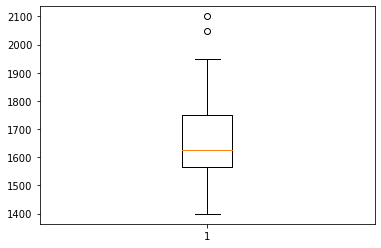

In [29]:
# evaluate cnn-lstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config 
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu',
      input_shape=(None,n_steps,1))))
    model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu'))) 
    model.add(TimeDistributed(MaxPooling1D())) 
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu')) 
    model.add(Dense(1)) 
    model.compile(loss='mse', optimizer='adam') # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions) 
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std)) # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()
     

series = read_csv('monthly-car-sales.csv', header=0, index_col=0) 
data = series.values
# data split
n_test = 12
# define config
config = [3, 12, 64, 3, 100, 200, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)

Running the example prints the RMSE for each repeated evaluation of the model. The final averaged RMSE is reported at the end of about 1,626, which is **lower** than the naive model, but still **higher** than a SARIMA model. The standard deviation of this score is also very large, suggesting that the chosen configuration may not be as stable as the standalone CNN model.

### 14.6.3 ConvLSTM

It is possible to perform a convolutional operation as part of the read of the input sequence within each LSTM unit. This means, rather than reading a sequence one step at a time, the LSTM would read a block or subsequence of observations at a time using a convolutional process, like a CNN. This is different to first reading an extracting features with an LSTM and interpreting the result with an LSTM; this is performing the CNN operation at each time step as part of the LSTM.

This type of model is called a Convolutional LSTM, or ConvLSTM for short. 

可以执行卷积操作，作为读取每个 LSTM 单元内输入序列的一部分。这意味着，LSTM 不是一次一步地读取一个序列，而是使用卷积过程（如 CNN）一次读取一个观察块或子序列。这与首先使用 LSTM 读取提取特征并使用 LSTM 解释结果不同;这是在每个时间步执行 CNN 操作，作为 LSTM 的一部分。
这种类型的模型称为卷积LSTM，简称ConvLSTM。

The output of the layer is a sequence of filter maps that must first be flattened before it can be interpreted and followed by an output layer. The model expects a list of seven hyperparameters, the same as the CNN-LSTM; they are:
- n seq: The number of subsequences within a sample.
- n steps: The number of time steps within each subsequence.
- n filters: The number of parallel filters.
- n kernel: The number of time steps considered in each read of the input sequence.
- n nodes: The number of LSTM units to use in the hidden layer.
- n epochs: The number of times to expose the model to the whole training dataset.
- n batch: The number of samples within an epoch after which the weights are updated.


In [ ]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(n_filters, (1,n_kernel), activation='relu', input_shape=(n_seq, 1,
    n_steps, 1)))
    model.add(Flatten())
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0) 
    return model

 > 1651.708
 > 2263.347
 > 1704.932
 > 1629.916
 > 1684.703
 > 1614.466
 > 2127.499
 > 1438.152
 > 1491.593
 > 1698.939
 > 2155.454
 > 1571.661
 > 2073.914
 > 1883.226
 > 2507.744
 > 2641.016
 > 2301.998
 > 1626.632
 > 1584.597
 > 1283.161
 > 2989.825
 > 1731.696
 > 1807.784
 > 2670.149
 > 2065.728
 > 1587.325
 > 1874.714
 > 1756.115
 > 1731.364
 > 1715.808
convlstm: 1895.506 RMSE (+/- 398.714)


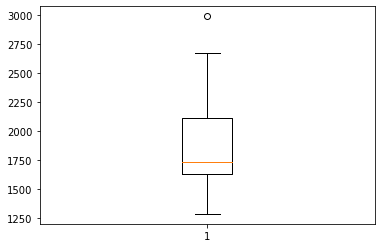

In [31]:
# evaluate cnn-lstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(n_filters, (1,n_kernel), activation='relu', input_shape=(n_seq, 1,
    n_steps, 1)))
    model.add(Flatten())
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0) 
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions) 
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std)) # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()


series = read_csv('monthly-car-sales.csv', header=0, index_col=0) 
data = series.values
# data split
n_test = 12
# define config
config = [3, 12, 64, 3, 100, 200, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('convlstm', scores)

## 14.7 Extensions

This section lists some ideas for extending the tutorial that you may wish to explore.
- **Data Preparation**. Explore whether data preparation, such as normalization, standard- ization, and/or differencing can list the performance of any of the models.
- **Grid Search Hyperparameters**. Implement a grid search of the hyperparameters for one model to see if you can further lift performance.
- **Learning Curve Diagnostics**. Create a single fit of one model and review the learning curves on train and validation splits of the dataset, then use the diagnostics of the learning curves to further tune the model hyperparameters in order to improve model performance.
- **History Size**. Explore different amounts of historical data (lag inputs) for one model to see if you can further improve model performance
- **Reduce Variance of Final Model**. Explore one or more strategies to reduce the variance for one of the neural network models.
- **Update During Walk-Forward**. Explore whether re-fitting or updating a neural
network model as part of walk-forward validation can further improve model performance.
- **More Parameterization**. Explore adding further model parameterization for one model, such as the use of additional layers.

## 14.9 Summary
In this tutorial, you discovered how to develop a suite of deep learning models for univariate time series forecasting. Specifically, you learned:
- How to develop a robust test harness using walk-forward validation for evaluating the performance of neural network models.
- How to develop and evaluate simple Multilayer Perceptron and convolutional neural networks for time series forecasting.
- How to develop and evaluate LSTMs, CNN-LSTMs, and ConvLSTM neural network models for time series forecasting.